In [2]:
import importlib
import Universial_Data_Functions
import Correlation_Matrix
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sktime.forecasting.compose import ForecastingPipeline, make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_longley
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense

#Reload the libary
importlib.reload(SQL_Connect)
importlib.reload(Correlation_Matrix)
if Universial_Data_Functions.Connection_With_DB: 
    test1 = Universial_Data_Functions.Visualaize_Data(sql_handler= Universial_Data_Functions.cursor,timestamp_begin='\'2024-01-10\'',database_name='822Raw',minutes_amount = 2000000)

    to_get = [
            'AC[2].AH[1].AR[1].ART[1].IV_PV_SCL',
            'AC[2].AH[1].AM[1].ATT[1].IV_PV_SCL',
            'AC[2].AH[1].AS[1].ART[1].IV_PV_SCL',
            'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',
            'AC[2].AH[1].AI[1].ATT[1].IV_PV_SCL',
            'AC[2].AH[1].AR[1].ATT[1].IV_PV_SCL',    
            'AC[2].AH[1].AH[1].SHU[1].IV_PV',
            'AC[2].AH[1].AC[1].WCV[1].IV_PV',
            'AC[2].AH[1].AP[1].AHE[1].IV_PV',
            'AC[2].AH[1].AC[1].WTT[1].IV_PV_SCL',        
            'AC[2].AH[1].AC[1].WTT[2].IV_PV_SCL',        
            'AC[2].AH[1].FM[1].FSC[1].IV_PV_SPD'
        ]

    custom = {
        'AC[2].AH[1].AC[1].WCV[1].IV_PV' : 'Cold water valve (%)',
        'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL' : 'Supply air temperature (°C)',
        'AC[2].AH[1].AM[1].ATT[1].IV_PV_SCL' : 'Mixing air temperature (°C)',
        'AC[2].AH[1].FM[1].FSC[1].IV_PV_SPD' : 'Supply fan speed (%)',
        'AC[2].AH[1].AI[1].ATT[1].IV_PV_SCL' : 'Intake air temperature (°C)',
        'AC[2].AH[1].AC[1].WTT[1].IV_PV_SCL' : 'Cold water inlet temeprature (°C)',
        'AC[2].AH[1].AC[1].WTT[2].IV_PV_SCL' : 'Cold water outlet temeprature (°C)',
        'AC[2].AH[1].AR[1].ART[1].IV_PV_SCL' : 'Return air humidity (%)',
        'AC[2].AH[1].AH[1].SHU[1].IV_PV':  'Steam humidifier output (%) ',
        'AC[2].AH[1].AS[1].ART[1].IV_PV_SCL': 'Supply air humidity (%)'
    }




    #print(test.__Get_Table__('AC[2].RA[6].CS[1].ATT[1].IV_PV_SCL'))
    test1.Create_DF(requests=to_get,fill_zero_room= True,fill_zero_other= True,AH_in_table= False)
    #test1.mask_off('AC[2].AH[1].FM[1].FSC[1].IV_PV_SPD',value= 0, minutes= 10)
    test1.mask_off('AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',value= 0, minutes= 2)
    #test1.mask_off('AC[2].AH[1].AC[1].WCV[1].IV_PV',value= 70, minutes= 2,greater_lower= 1)
    #test1.mask_off('AC[2].AH[1].AC[1].WCV[1].IV_PV',value= 30, minutes= 2,greater_lower= 2)   
    #test1.interpolate(reset_index = True)
    print(test1.df.head())
    test1.shorten_all_gaps(steps = 20,reset_index= True)
    
print(test1.df.head())
test1.upper_range = 30
# Check for NaNs in the index
#test1.Plot_Data()


InterfaceError: ('28000', "[28000] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]Login failed for user 'SA'. (18456) (SQLDriverConnect)")

In [2]:
from sklearn.preprocessing import MinMaxScaler
#Noralise the train data X
scaler = MinMaxScaler()
def normalize_with_DT(df):
    #Split the dataframe in datetime columns and numerical columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    numerical_cols = df.select_dtypes(include=['float64','int64']).columns
    #apply the scaler to the numerical columns
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    #Return the combined and transformed dataframe 
    return pd.concat([ df[numerical_cols]], axis=1)

In [6]:
#For the scaler get the lowest and the highest lowest values
lower_range_valve, upper_range_valve = test1.retun_min_max(column= 'AC[2].AH[1].AC[1].WCV[1].IV_PV',df_External= test1.df)
lower_range_temp, upper_range_temp = test1.retun_min_max(column= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',df_External= test1.df)
#Drop the timestamp from the dataframes
lower_range_valve.drop('Timestamp',axis= 1,inplace= True)
upper_range_valve.drop('Timestamp',axis= 1,inplace= True)

#Drop the supply temeprature
lower_range_valve.drop('AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',axis= 1,inplace= True)
upper_range_valve.drop('AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',axis= 1,inplace= True)

#This is a function that converts the data within the dataframe range
def normalize_scale(min,max,input):
    if input >= min and input <= max:
        result = (input-min) / (max-min)
        return result
    elif input < min:
        return 0
    else:
        return 1
low_temp = lower_range_temp['AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL'].values[0]
high_temp = upper_range_temp['AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL'].values[0]

#This is a function that converts the data within the dataframe range
def normalize_scale(min,max,input):
    if input >= min and input <= max:
        result = (input-min) / (max-min)
        return result
    elif input < min:
        return 0
    else:
        return 1

print(low_temp)
Temp_diff = normalize_scale(min = low_temp, max= high_temp , input = 11.2)
print(Temp_diff)

10.200000000000001
0.08196721311475394


In [7]:
test1.df['Timestamp'] = pd.to_datetime(test1.df['Timestamp'])
timestamp = test1.df['Timestamp']
# Extract the hour of day and replace the 'Timestamp' column
y = test1.df[['AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', 'Timestamp']]
train_y, test_y =train_test_split(y, test_size=0.2,train_size= 0.8, shuffle= False)
train_y.drop(['Timestamp'],axis = 1, inplace= True)
test_y_2 =  test_y.copy()
test_y.drop(['Timestamp'],axis = 1,inplace= True)
test_y.reset_index(drop= True,inplace= True)

test1.df['Timestamp'] = pd.to_datetime(test1.df['Timestamp'])
#Normalize the whole dataframe
inter_df = normalize_with_DT(test1.df)
train, test = train_test_split(inter_df, test_size=0.2,train_size= 0.8, shuffle= False)
test.reset_index(drop= True,inplace= True)
#Replace the scaled Y for the non scaled Y
train.drop('AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',axis= 1,inplace= True)
train =pd.concat([train,train_y],axis = 1)
print(train_y.head())

   AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL
0                                18.2
1                                18.2
2                                18.2
3                                18.2
4                                18.2


In [8]:
#Create a object with datapoints
Data_change = []
Data_To_Alter = []
Data_To_Alter.append(SQL_Connect.Data_Add(column= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', add= 2.0))
Data_To_Alter.append(SQL_Connect.Data_Add(column= 'AC[2].AH[1].AC[1].WCV[1].IV_PV', add= -0.2))
Data_change.append(Data_To_Alter)

Data_To_Alter = []
Data_To_Alter.append(SQL_Connect.Data_Add(column= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', add= -2.0))
Data_To_Alter.append(SQL_Connect.Data_Add(column= 'AC[2].AH[1].AC[1].WCV[1].IV_PV', add= 0.2))
Data_change.append(Data_To_Alter)

Data_To_Alter = []
Data_To_Alter.append(SQL_Connect.Data_Add(column= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', add= 4))
Data_To_Alter.append(SQL_Connect.Data_Add(column= 'AC[2].AH[1].AC[1].WCV[1].IV_PV', add= -0.4))
Data_change.append(Data_To_Alter)

Data_To_Alter = []
Data_To_Alter.append(SQL_Connect.Data_Add(column= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', add= -4))
Data_To_Alter.append(SQL_Connect.Data_Add(column= 'AC[2].AH[1].AC[1].WCV[1].IV_PV', add= 0.4))
Data_change.append(Data_To_Alter)


train = test1.extend_df(start = 0,length= 70000,to_change=Data_change,interpolate_steps= 30,timestamp_begin= '\'2024-01-05\'',df_external=train,df_copy=train,pyramid=True,gaussian= True)



2.0
-0.2
-2.0
0.2
4
-0.4
-4
0.4
Interpolated 30
External
Interpolated 30
External
Interpolated 30
External
Interpolated 30
External
   AC[2].AH[1].AR[1].ART[1].IV_PV_SCL  AC[2].AH[1].AS[1].ART[1].IV_PV_SCL  \
0                            0.389831                            0.305556   
1                            0.389831                            0.375000   
2                            0.389831                            0.375000   
3                            0.389831                            0.277778   
4                            0.389831                            0.375000   

   AC[2].AH[1].AH[1].SHU[1].IV_PV  AC[2].AH[1].AM[1].ATT[1].IV_PV_SCL  \
0                            0.77                            0.232558   
1                            0.77                            0.238372   
2                            0.77                            0.232558   
3                            0.77                            0.232558   
4                            0.77       

/home/Digital_Twin/Finished/SQL_Connect.py:647: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_range = pd.date_range(start= start,periods= len(df_pointer), freq= 'T')


In [9]:
    custom = {
        'AC[2].AH[1].AC[1].WCV[1].IV_PV' : 'Cold water valve (%)',
        'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL' : 'Supply air temperature (°C)',
        'AC[2].AH[1].AM[1].ATT[1].IV_PV_SCL' : 'Mixing air temperature (°C)',
        'AC[2].AH[1].FM[1].FSC[1].IV_PV_SPD' : 'Supply fan speed (%)',
        'AC[2].AH[1].AI[1].ATT[1].IV_PV_SCL' : 'Intake air temperature (°C)',
        'AC[2].AH[1].AC[1].WTT[1].IV_PV_SCL' : 'Cold water inlet temeprature (°C)',
        'AC[2].AH[1].AC[1].WTT[2].IV_PV_SCL' : 'Cold water outlet temeprature (°C)',
        'AC[2].AH[1].AR[1].ART[1].IV_PV_SCL' : 'Return air humidity (%)',
        'AC[2].AH[1].AH[1].SHU[1].IV_PV':  'Steam humidifier output (%) ',
        'AC[2].AH[1].AS[1].ART[1].IV_PV_SCL': 'Supply air humidity (%)', 
        'AC[2].AH[1].AR[1].ATT[1].IV_PV_SCL': 'Return air temperature (°C)',
        'AC[2].AH[1].AP[1].AHE[1].IV_PV': 'Preheater output (%)'
    }

In [10]:
print(len(train))
print(train.tail())
train.drop(['Timestamp'],axis = 1, inplace= True)

453030
        AC[2].AH[1].AR[1].ART[1].IV_PV_SCL  \
453025                            0.457627   
453026                            0.457627   
453027                            0.457627   
453028                            0.457627   
453029                            0.457627   

        AC[2].AH[1].AS[1].ART[1].IV_PV_SCL  AC[2].AH[1].AH[1].SHU[1].IV_PV  \
453025                            0.597222                             0.0   
453026                            0.583333                             0.0   
453027                            0.569444                             0.0   
453028                            0.569444                             0.0   
453029                            0.569444                             0.0   

        AC[2].AH[1].AM[1].ATT[1].IV_PV_SCL  \
453025                            0.290698   
453026                            0.296512   
453027                            0.296512   
453028                            0.296512   
453029           

In [11]:
#test1.df = normalize(test1.df)
#test1.Plot_Data()

#print(test)

#train_x = train.drop('AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',axis= 1)

test_x = test.drop('AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',axis= 1)
#print(test['Timestamp'])
test_x_Lowered = test_x.copy()
test_x_Upperd = test_x.copy()
test_x_Lowered['AC[2].AH[1].AC[1].WCV[1].IV_PV'] = test_x_Lowered['AC[2].AH[1].AC[1].WCV[1].IV_PV'].apply(lambda x: max(x - 0.3, -1))
test_x_Upperd['AC[2].AH[1].AC[1].WCV[1].IV_PV'] = test_x_Upperd['AC[2].AH[1].AC[1].WCV[1].IV_PV'].apply(lambda x: min(x + 0.3, 1))

#Add the min and max dataframes to the upperd and lowerd test sets
#test_x_lowerd = test1.__interpolate_and_concat__(df = lower_range_valve ,steps= 10,df_External= test_x_Lowered)
#test_x_Upperd = test1.__interpolate_and_concat__(df = upper_range_valve ,steps= 10,df_External= test_x_Upperd)


test_Com =pd.concat([test_x,test_y],axis = 1)
test_Com_l =pd.concat([test_x_Lowered,test_y],axis = 1)
test_Com_u =pd.concat([test_x_Upperd,test_y],axis = 1)
#Noralise the train data X

print(test_y.head())

   AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL
0                                13.4
1                                13.4
2                                13.3
3                                13.4
4                                13.4


In [12]:
#Create a sliding window of the regression model
def create_sliding_window(df, target_col, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i + window_size].drop(columns=[target_col]).values.flatten()
        X.append(window)
        y.append(df.iloc[i + window_size][target_col])
    return np.array(X), np.array(y)

window_train_X, window_train_Y = create_sliding_window(df = train, target_col= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',window_size= 120)
window_test_X, window_test_Y_np = create_sliding_window(df = test_Com, target_col= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',window_size= 120)
window_test_X_l, window_test_Y_np_s = create_sliding_window(df = test_Com_l, target_col= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',window_size= 120)
window_test_X_u, window_test_Y_np_d = create_sliding_window(df = test_Com_u, target_col= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',window_size= 120)

#print(size(window_test_Y_np))
window_test_Y = pd.DataFrame(window_test_Y_np, columns=['AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL'])

In [13]:
window_train_X, window_train_Y = create_sliding_window(df=train, target_col='AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', window_size=120)

In [15]:
window_test_X, window_test_Y_np = create_sliding_window(df=test_Com, target_col='AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', window_size=120)
window_test_x_lowerd, temp = create_sliding_window(df=test_Com_l, target_col='AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', window_size=120)
window_test_x_upperd, temp = create_sliding_window(df=test_Com_u, target_col='AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', window_size=120)

In [13]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import root_mean_squared_error
regr = LinearRegression() 
  
regr.fit(window_train_X, window_train_Y)


LinearRegression()

In [14]:
print(regr.score(window_test_X, window_test_Y_np)) 


-1.3754339353880813


In [15]:
test_y_plot = pd.concat([window_test_Y,timestamp],axis= 1)
#test_y_plot.reset_index(inplace=True)


print(test_y_plot)

        AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL           Timestamp
0                                     13.4 2024-01-10 00:00:00
1                                     13.4 2024-01-10 00:01:00
2                                     13.4 2024-01-10 00:02:00
3                                     13.3 2024-01-10 00:03:00
4                                     13.4 2024-01-10 00:04:00
...                                    ...                 ...
216133                                 NaN 2024-06-08 02:13:00
216134                                 NaN 2024-06-08 02:14:00
216135                                 NaN 2024-06-08 02:15:00
216136                                 NaN 2024-06-08 02:16:00
216137                                 NaN 2024-06-08 02:17:00

[216138 rows x 2 columns]


In [16]:
import matplotlib.pyplot as plt 
test_y.reset_index(drop= True,inplace= True)
test1.lower_range = 0
test1.upper_range = 30
y_pred = regr.predict(window_test_X) 
y_pred_l = regr.predict(window_test_X_l)
y_pred_u = regr.predict(window_test_X_u)




In [17]:
test_y_2.reset_index(drop= True,inplace= True)

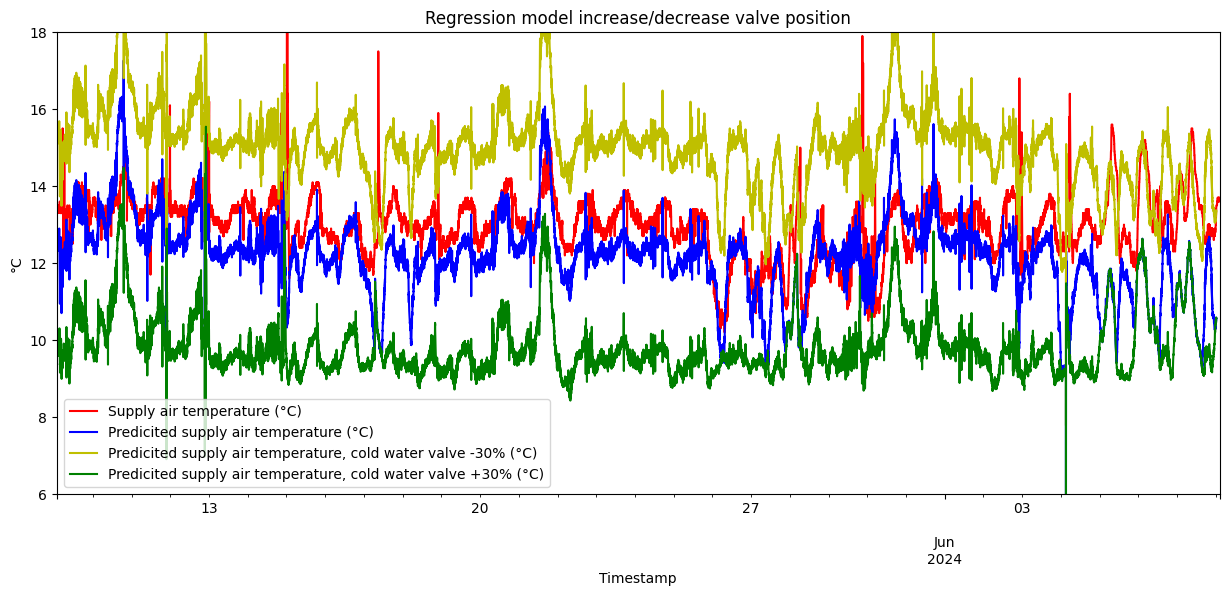

<Figure size 20000x600 with 0 Axes>

<Figure size 1500x8000 with 0 Axes>

In [21]:
test1.lower_range = 6
test1.upper_range = 18
y_preddf = pd.DataFrame(y_pred,columns=['Predicited supply air temperature (°C)'])
y_preddf_Less = pd.DataFrame(y_pred_l,columns=['Predicited supply air temperature, cold water valve -30% (°C)'])
y_preddf_More = pd.DataFrame(y_pred_u,columns=['Predicited supply air temperature, cold water valve +30% (°C)'])
test1.amount_of_Plots = 1 
df_result = pd.concat([test_y_2,y_preddf,y_preddf_Less,y_preddf_More],axis = 1)
test1.Plot_Custom(df_in=df_result,title='Regression model increase/decrease valve position',custom_names=custom,light_mode=True,legend_heigth= -0.2,y_title_1= '°C')

KeyError: 'Timestamp'

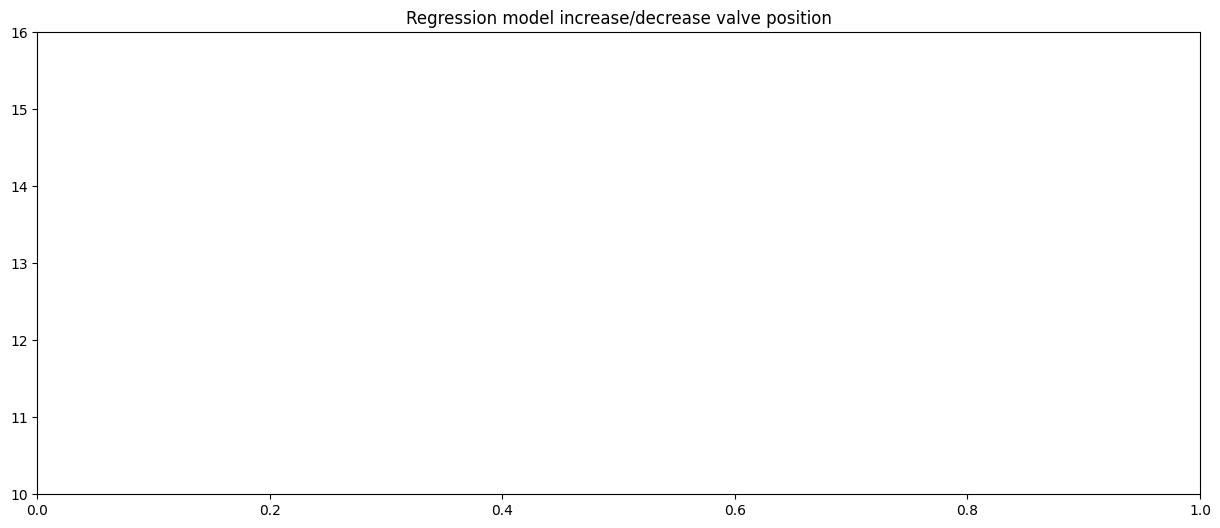

<Figure size 20000x600 with 0 Axes>

<Figure size 1500x8000 with 0 Axes>

In [ ]:
test1.lower_range = 10
test1.upper_range = 16
test1.amount_of_Plots =1
#test1.Plot_Custom(df_in=df_result,title='Regression model',custom_names=custom,light_mode=True,legend_heigth= -0.2,y_title_1='°C')
test1.Plot_Custom(df_in=df_result,title='Regression model increase/decrease valve position',custom_names=custom,light_mode=True,legend_heigth= -0.2,y_title_1='°C')
#df_result.plot(ax=self.ax, style=self.style, x = 'Timestamp')
test1.rese

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(window_test_Y_np, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.39127440536880476


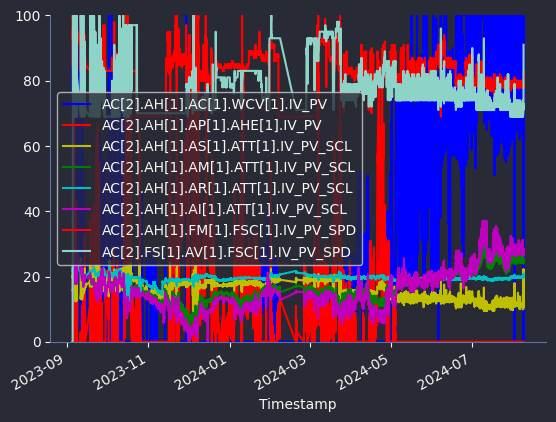

In [101]:

#mask = test1.df.apply(lambda row: any((row['Timestamp'] >= start) &(row['Timestamp'] <= end) for start, end in zip(fan_off["Timestamp"],fan_off['end_time'])),axis=1)
test1.Plot_Data()